# NFL Match Data - Scoring Team Skill Using ELO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm.auto import tqdm

In [3]:
from elo_handling import elo_match_handler

In [4]:
df = pd.read_csv("Data/processed_game_history.csv", dtype={"ModifiedWeek": int}, parse_dates=["Date"])
df = df.drop(["Unnamed: 0", "AtHome"], axis=1)

In [5]:
df = df.sort_values(by="Date", ascending=True)

In [6]:
# ELO Config
k = 20
beta = 1000
START_SCORE = 1500.0
seasons = df["Season"].unique().tolist()

### Establish the starting points for every season

In [7]:

base_elo_df = pd.DataFrame(columns=["Season", "Week", "Date", "Team", "Score"])
base_elo_df["Score"] = base_elo_df["Score"].astype(float)

for season in seasons:
    season_df = df[df["Season"] == season] # table of just that season
    start_date = season_df["Date"].values.min() # season start date
    teams = list(set(list(season_df["Winner/tie"]) + list(season_df["Loser/tie"]))) 
    for team in teams:
        new_row = {"Season": season,
                   "Week": 0,
                   "Date": start_date,
                   "Team": team,
                   "Score": START_SCORE}
        base_elo_df = base_elo_df.append(new_row,
                                         ignore_index=True)

In [8]:
def get_prior_elo_score_pdf(table, team_name, current_week, season, continuous_scoring=False):
    prior_week = current_week-1
    found = False
    if (continuous_scoring) & (prior_week == 0):
        season = season -1
    while not found:
        if prior_week == 0:
            score = 1500
            found = True
        else:
            matching_row = table[(table["Team"] == team_name) & (table["Season"] == season) & (table["Week"] == prior_week)]
            if len(matching_row) != 1:
                found=False
            else:
                score = matching_row["Score"].values[0]
                found=True
    return score

### Run ELO with no connection to prior season

In [9]:
elo_df = base_elo_df.copy()
most_recent = {}

for game_season in seasons:
    season_df = df[df["Season"] == game_season]
    for game_week in season_df["ModifiedWeek"].unique():
        week_df = season_df[season_df["ModifiedWeek"] == game_week]
        for index, row in week_df.iterrows():
            game_date = row["Date"]
            team_a = row["Winner/tie"]
            team_b = row["Loser/tie"]
            team_a_score = row["PtsW"]
            team_b_score = row["PtsL"]
            team_a_str = f"{game_season}_{team_a}"
            team_b_str = f"{game_season}_{team_b}"
            
            if team_a_str not in most_recent:
                most_recent[f"{game_season}_{team_a}"] = START_SCORE
            if team_b_str not in most_recent:
                most_recent[f"{game_season}_{team_b}"] = START_SCORE
            if game_week == 1:
                team_a_elo = START_SCORE
                team_b_elo = START_SCORE
            else:
                team_a_elo = most_recent.get(team_a_str, START_SCORE)
                team_b_elo = most_recent.get(team_b_str, START_SCORE)
                
            elo_obj = elo_match_handler(team_a_elo, team_b_elo, team_a_score, team_b_score, k, beta)
            newscore_a, newscore_b = elo_obj.get_updated_scores()
            most_recent[team_a_str] = newscore_a
            most_recent[team_b_str] = newscore_b
            exp_a = elo_obj.exp_outcome_team1
            exp_b = elo_obj.exp_outcome_team2
            exp_error_a = elo_obj.exp_error_a
            exp_error_b = elo_obj.exp_error_b
                    
            elo_df = elo_df.append({"Season": game_season, "Week": game_week, "Date": game_date, "Team": team_a, "Score": newscore_a, "Expected": exp_a, "Exp_Error": exp_error_a},
                                ignore_index=True)
            elo_df = elo_df.append({"Season": game_season, "Week": game_week, "Date": game_date, "Team": team_b, "Score": newscore_b, "Expected": exp_b, "Exp_Error": exp_error_b},
                                ignore_index=True)


## NFL 2020 Season - ELO Scores

In [20]:
import json

with open("team_colours.json") as f:
  colours_json = json.load(f)
  color_dict = {}
for key, val in colours_json.items():
    color_dict[key] = val.get("primary", "#000000")

In [21]:
season_2020 = elo_df[elo_df["Season"] == 2020]

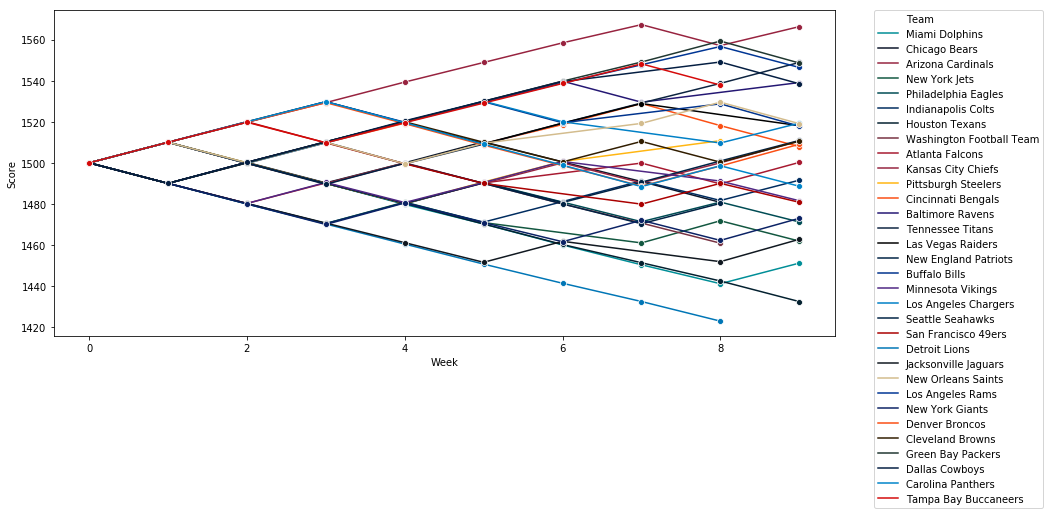

In [23]:
plt.subplots(figsize=(14, 6))
sns.lineplot(data=season_2020, x="Week", y="Score", hue="Team", marker="o", palette=color_dict)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Plotly Version

In [ ]:
import plotly.express as px

In [ ]:
fig = px.line(season_2020, x="Week", y="Score", color="Team", color_discrete_map=color_dict)
fig.update_layout(title="ELO Scoring of the 202 NFL Season")
fig.show()